# Imports

In [1]:
import importlib
import sys
import torch

sys.path.insert(0, '..')
sys.path.insert(0, '../..')
sys.path.insert(0, '../../..')
sys.path.insert(0, '../../../..')

# Data

### Load Data Files

In [2]:
# Path to your pickle file (saved with torch.save)
file_path_train = '../../../../encoded_data/log_stand/repair_shop_all_lognormal_5_train.pkl'
# Load the dataset using torch.load
repair_train_dataset = torch.load(file_path_train, weights_only=False)
# Check the type of the loaded dataset
print(type(repair_train_dataset))  # Should output something like <class 'torch.utils.data.dataset.TensorDataset'>

# Path to your pickle file (saved with torch.save)
file_path_val = '../../../../encoded_data/log_stand/repair_shop_all_lognormal_5_val.pkl'
# Load the dataset using torch.load
repair_val_dataset = torch.load(file_path_val, weights_only=False)
# Check the type of the loaded dataset
print(type(repair_val_dataset))  # Should output something like <class 'torch.utils.data.dataset.TensorDataset'>

<class 'event_log_loader.new_event_log_loader.EventLogDataset'>
<class 'event_log_loader.new_event_log_loader.EventLogDataset'>


### Train Data Insights

In [3]:
# Repair Shop Dataset Categories, Features:

repair_all_categories = repair_train_dataset.all_categories

repair_all_categories_cat = repair_all_categories[0]
print(repair_all_categories_cat)

repair_all_categories_num = repair_all_categories[1]
print(repair_all_categories_num)

for i, cat in enumerate(repair_all_categories_cat):
     print(f"Repair Shop (5) Categorical feature: {cat[0]}, Index position in categorical data list: {i}")
     print(f"Repair Shop (5) Total Amount of Category labels: {cat[1]}")
print('\n')    
for i, num in enumerate(repair_all_categories_num):
     print(f"Repair Shop (5) Numerical feature: {num[0]}, Index position in categorical data list: {i}")
     print(f"Repair Shop (5) Amount Category Lables: {num[1]}")

[('concept:name', 9, {'ACKNOWLEDGEMENT': 1, 'CREATE_INVOICE': 2, 'DISASSEMBLY': 3, 'EOS': 4, 'QUALITY_CONTROL': 5, 'RECEPTION': 6, 'REPAIR': 7, 'SHIPPING': 8})]
[('day_in_week', 1, {}), ('seconds_in_day', 1, {}), ('case_elapsed_time', 1, {}), ('event_elapsed_time', 1, {})]
Repair Shop (5) Categorical feature: concept:name, Index position in categorical data list: 0
Repair Shop (5) Total Amount of Category labels: 9


Repair Shop (5) Numerical feature: day_in_week, Index position in categorical data list: 0
Repair Shop (5) Amount Category Lables: 1
Repair Shop (5) Numerical feature: seconds_in_day, Index position in categorical data list: 1
Repair Shop (5) Amount Category Lables: 1
Repair Shop (5) Numerical feature: case_elapsed_time, Index position in categorical data list: 2
Repair Shop (5) Amount Category Lables: 1
Repair Shop (5) Numerical feature: event_elapsed_time, Index position in categorical data list: 3
Repair Shop (5) Amount Category Lables: 1


### Input Features for Encoder and Decoder

In [4]:
# Create lists with name of Encoder features (input) and decoder features (input & output)

# Encoder features:
enc_feat_cat = []
enc_feat_num = []
for cat in repair_all_categories_cat:
    enc_feat_cat.append(cat[0])
for num in repair_all_categories_num:
    enc_feat_num.append(num[0])
enc_feat = [enc_feat_cat, enc_feat_num]
print("Input features encoder: ", enc_feat)

# Decoder features:
dec_feat_cat = enc_feat_cat
dec_feat_num = ['case_elapsed_time', 'event_elapsed_time']
dec_feat = [dec_feat_cat, dec_feat_num]
print("Features decoder: ", dec_feat)

Input features encoder:  [['concept:name'], ['day_in_week', 'seconds_in_day', 'case_elapsed_time', 'event_elapsed_time']]
Features decoder:  [['concept:name'], ['case_elapsed_time', 'event_elapsed_time']]


# Model

In [5]:
import model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model
importlib.reload(model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model)
from model.dropout_uncertainty_enc_dec_LSTM.dropout_uncertainty_model import DropoutUncertaintyEncoderDecoderLSTM

# Prediction decoder output sequence length
seq_len_pred = 4

# Size hidden layer
hidden_size = 128

# Number of cells
num_layers = 4

# Fixed Dropout probability 
dropout = 0.1

# Encoder Decoder model initialization
model = DropoutUncertaintyEncoderDecoderLSTM(data_set_categories=repair_all_categories,
                                             enc_feat=enc_feat,
                                             dec_feat=dec_feat,
                                             seq_len_pred=seq_len_pred,
                                             hidden_size=hidden_size,
                                             num_layers=num_layers,
                                             dropout=dropout)

Data set categories:  ([('concept:name', 9, {'ACKNOWLEDGEMENT': 1, 'CREATE_INVOICE': 2, 'DISASSEMBLY': 3, 'EOS': 4, 'QUALITY_CONTROL': 5, 'RECEPTION': 6, 'REPAIR': 7, 'SHIPPING': 8})], [('day_in_week', 1, {}), ('seconds_in_day', 1, {}), ('case_elapsed_time', 1, {}), ('event_elapsed_time', 1, {})])
Encoder input features:  [['concept:name'], ['day_in_week', 'seconds_in_day', 'case_elapsed_time', 'event_elapsed_time']]
Decoder input+output features:  [['concept:name'], ['case_elapsed_time', 'event_elapsed_time']]


Sequence length of decoder output:  4


Cells hidden size:  128
Number of LSTM layer:  4
Dropout rate:  0.1


Encoder number of labels for each input feature (categorical, numerical):  [[9], [1, 1, 1, 1]]
Encoder indices of tensors in dataset used as input:  [[0], [0, 1, 2, 3]]
Embeddings encoder:  ModuleList(
  (0): Embedding(9, 5)
)
Total embedding feature size encoder:  5
Total numerical feature size encoder:  4
Input feature size encoder:  9
Encoder initialized! 

Decoder 

# Loss Object Creation

In [6]:
import loss.losses
importlib.reload(loss.losses)
from loss.losses import Loss

loss_obj = Loss()

# Numerical features trained with log-normal loss:
log_normal_loss_num_feature = ['case_elapsed_time', 'event_elapsed_time']

# Training Configuration

In [7]:
import trainer.trainer
importlib.reload(trainer.trainer)
from trainer.trainer import Trainer
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(comment="Full_Repair_shop_grad")

# device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start learning rate
learning_rate = 1e-4

# Optimizer and Scheduler
optimizer = torch.optim.AdamW(params=model.parameters(), lr=learning_rate, weight_decay=0)

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=1e-5, patience=1, min_lr=1e-10)

# Epochs
num_epochs = 100

# BATCHING does not work currntly with custom implementation
batch_size = 128

# lambda for L2 (weight, bias, dropout) regularization: According to formula: 1/2N
# regularization_term = 1.0/(2.0*batch_size)
regularization_term =  1e-4

# shuffle data
shuffle = True

# Teacher forcing: Smaller 0.5 more target events are used for next event prediction.
teacher_forcing_ratio = 0.8

optimize_values = {"regularization_term":regularization_term,
                   "optimizer":optimizer,
                   "scheduler": scheduler,
                   "epochs":num_epochs,
                   "mini_batches":batch_size,
                   "shuffle": shuffle,
                   "teacher_forcing_ratio":teacher_forcing_ratio,}

suffix_data_split_value = 4

# GradNorm parameter
use_gradnorm = True
gn_alpha = 1.5
gn_learning_rate = 1e-4
# gn_learning_rate =  0.025

number_tasks = len(dec_feat[0]) + len(dec_feat[1])

gradNorm = {"use_gradnorm":use_gradnorm,
            "number_tasks": number_tasks,
            "gn_alpha":gn_alpha,
            "gn_learning_rate": gn_learning_rate}

## Changed name because of good results of actual model

trainer = Trainer(device=device,
                  model=model,
                  data_train=repair_train_dataset,
                  data_val=repair_val_dataset,
                  loss_obj=loss_obj,
                  log_normal_loss_num_feature=log_normal_loss_num_feature,
                  optimize_values=optimize_values,
                  suffix_data_split_value=suffix_data_split_value,
                  writer=writer,
                  gradnorm_values=gradNorm,
                  save_model_n_th_epoch = 1,
                  saving_path = 'repair_shop_full_grad_lognorm_v1.pkl')

# Train the model:
train_attenuated_losses, val_losses, val_attenuated_losses = trainer.train_model()

Device:  cuda
Model:  DropoutUncertaintyEncoderDecoderLSTM(
  (embeddings_enc): ModuleList(
    (0): Embedding(9, 5)
  )
  (encoder): DropoutUncertaintyLSTMEncoder(
    (embeddings): ModuleList(
      (0): Embedding(9, 5)
    )
    (first_layer): DropoutUncertaintyLSTMCell(
      (Wi): Linear(in_features=9, out_features=128, bias=True)
      (Ui): Linear(in_features=128, out_features=128, bias=True)
      (Wf): Linear(in_features=9, out_features=128, bias=True)
      (Uf): Linear(in_features=128, out_features=128, bias=True)
      (Wc): Linear(in_features=9, out_features=128, bias=True)
      (Uc): Linear(in_features=128, out_features=128, bias=True)
      (Wo): Linear(in_features=9, out_features=128, bias=True)
      (Uo): Linear(in_features=128, out_features=128, bias=True)
    )
    (hidden_layers): ModuleList(
      (0-2): 3 x DropoutUncertaintyLSTMCell(
        (Wi): Linear(in_features=128, out_features=128, bias=True)
        (Ui): Linear(in_features=128, out_features=128, bias=T

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch [1/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 1.4593
Validation: Avg Standard Validation Loss: 2.6189
Validation: Avg Attenuated Validation Loss: 0.9789
Validation Loss for Scheduler: 2.6189
saving model
Epoch [2/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: 0.1669
Validation: Avg Standard Validation Loss: 2.1270
Validation: Avg Attenuated Validation Loss: -0.0462
Validation Loss for Scheduler: 2.1270
saving model
Epoch [3/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -0.6279
Validation: Avg Standard Validation Loss: 1.9867
Validation: Avg Attenuated Validation Loss: -0.2075
Validation Loss for Scheduler: 1.9867
saving model
Epoch [4/100], Learning Rate: 0.0001, Teacher forcing ratio: 0.8
Training: Avg Attenuated Training Loss: -1.0636
Validation: Avg Standard Validation Loss: 1.8829
Validation: Avg Attenuated Validation Loss: -0

# Training Visualization

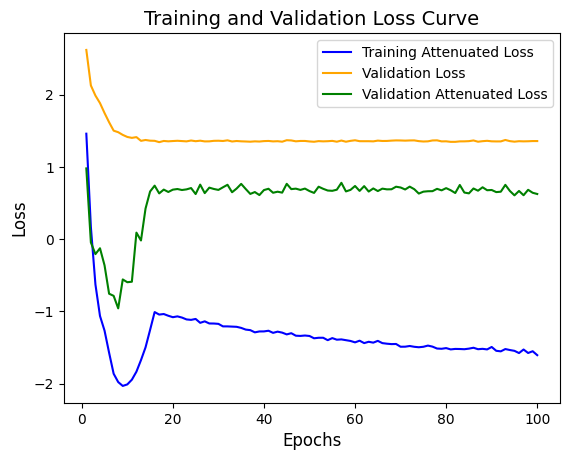

In [8]:
import matplotlib.pyplot as plt

# After training is finished, plot the loss curves
plt.plot(range(1, num_epochs+1), train_attenuated_losses, label='Training Attenuated Loss', color='blue')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss', color='orange')
plt.plot(range(1, num_epochs+1), val_attenuated_losses, label='Validation Attenuated Loss', color='green')
# Labeling x and y axes
plt.xlabel('Epochs', fontsize=12)
plt.ylabel('Loss', fontsize=12)
# Adding title
plt.title('Training and Validation Loss Curve', fontsize=14)
# Adding legend
plt.legend()
# Show the plot
plt.show()